<a href="https://colab.research.google.com/github/LysandreLT/OsuMapCreator/blob/ElementPlacement/ElementPlacementIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install audio2numpy
!pip install pydub
#Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=ac2b4495a1db3800d9adddb4fadfc3090a1a4c1f62fab7f8670607bda6963aff
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
import math
import audio2numpy as a2n
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import layers
import pydub
import numpy as np

"""
Unet, deeplearning
Entrées : .txt, .MP3 (x minutes max)
Sortie : .txt
"""

'\nUnet, deeplearning\nEntrées : .txt, .MP3 (x minutes max)\nSortie : .txt\n'

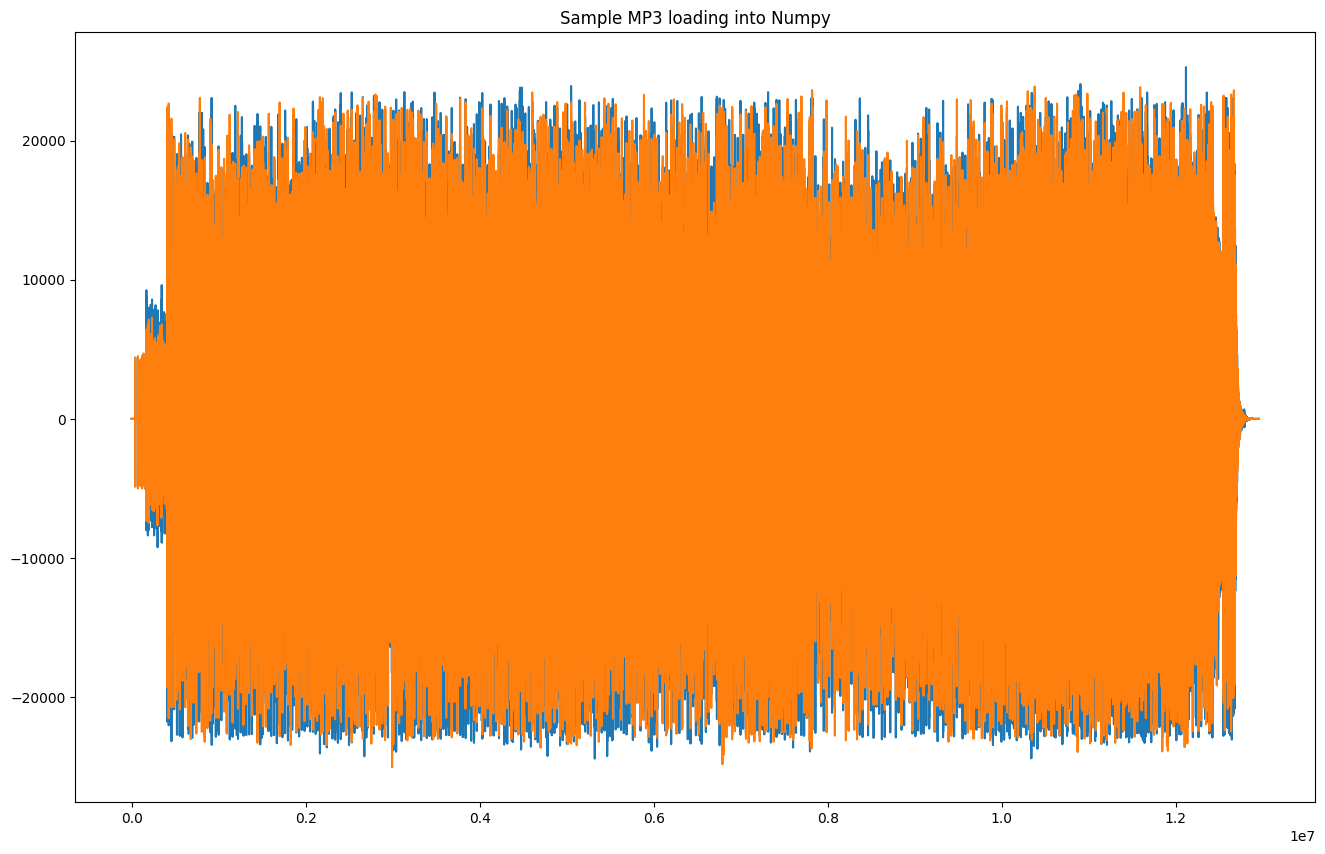

25910784


In [ ]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y


def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")


audio_name = "Billy Idol - Rebel Yell"
audio_file = '/content/drive/MyDrive/ ' + audio_name + '.mp3'
sr, x = read(audio_file)
# write("NumpyWrite "+ audio_name, sr, x)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(x)
plt.title("Sample MP3 loading into Numpy")
plt.show()
print(x.size)

In [ ]:
# Hyperparamètres

# data
dataset_name = "OsuMaps"
dataset_repetitions = 1
num_epochs = 2  # train for at least 50 epochs for good results
audio_size = 10000

plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [ ]:
# Fonctions

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def getNetwork(audio_file, beatmap, widths, block_depth):
    music = keras.Input(shape=audio_file.shape())
    noisy_beatmaps = keras.Input(shape=(beatmap.shape()))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=musicDuration, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_beatmaps, noise_variances], x, name="residual_unet")


def networkSummary(model):
    """"TODO"""

    tf.keras.utils.plot_model(getNetwork(10000, widths, 2), to_file="modelPlot.png", show_shapes=False,
                              show_layer_names=True)

In [ ]:
# Modèle
class ElementPlacementIA(Model):
    def __init__(self, audio_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(audio_file, beatmap, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, beatmaps):
        # convert the pixel values back to 0-1 range
        beatmaps = self.normalizer.mean + beatmaps * self.normalizer.variance**0.5
        return tf.clip_by_value(beatmaps, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_beatmaps, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_beatmaps, noise_rates**2], training=training)
        pred_beatmaps = (noisy_beatmaps - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_beatmaps

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_beatmaps = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy beatmap" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_beatmaps = next_noisy_beatmaps

            # separate the current noisy beatmap to its components
            diffusion_times = tf.ones((num_beatmaps, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_beatmaps = self.denoise(
                noisy_beatmaps, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_beatmaps + next_noise_rates * pred_noises
            )
            # this new noisy beatmap will be used in the next step

        return pred_beatmaps

    def generate(self, num_beatmaps, diffusion_steps):
        # noise -> images -> denormalized beatmaps
        initial_noise = tf.random.normal(shape=(num_beatmaps, beatmap_size, image_size, 3))
        generated_beatmaps = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_beatmaps = self.denormalize(generated_beatmaps)
        return generated_beatmaps

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()